In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython.display import display, HTML
show_html = lambda html: display(HTML(html))

from time import time
from datetime import timedelta

import pandas as pd
from pandas import read_csv

import numpy as np
from numpy.random import choice
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import set_config

from sklearn.metrics import  ConfusionMatrixDisplay,\
                  classification_report,  RocCurveDisplay, PrecisionRecallDisplay,\
                    accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import mean_squared_error, make_scorer, mean_absolute_error

from sklearn.decomposition import PCA
from sklearn.manifold import LocallyLinearEmbedding

from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor


from sklearn.inspection import permutation_importance
from sklearn.model_selection import GridSearchCV,train_test_split, cross_val_score, TimeSeriesSplit

from yellowbrick.classifier.rocauc import roc_auc
from yellowbrick.target.feature_correlation import feature_correlation
from yellowbrick.classifier import precision_recall_curve

from apafib import load_electric_devices, load_energy

import warnings

set_config(display='text')
warnings.filterwarnings('ignore')
plt.rcParams.update({'font.size': 16})
# sns.set()
pd.set_option('display.precision', 3)

In [2]:
df = pd.read_csv('weatherDef.csv')
df

,Loc,MinT,MaxT,Rain,WDir,WSpeed,WDir9,WDir3,WSpeed9,WSpeed3,Hum9,Hum3,Press9,Press3,Temp9,Temp3,Rtod,RTom
0,0,13.4,22.9,0.6,13,44,13,14,20,24,71,22,1007.7,1007.1,16.9,21.8,0,0
1,0,7.4,25.1,0.0,14,44,6,15,4,22,44,25,1010.6,1007.8,17.2,24.3,0,0
2,0,17.5,32.3,1.0,13,41,1,7,7,20,82,33,1010.8,1006.0,17.8,29.7,0,0
3,0,14.6,29.7,0.2,14,56,13,13,19,24,55,23,1009.2,1005.4,20.6,28.9,0,0
4,0,7.7,26.7,0.0,13,35,10,13,6,17,48,19,1013.4,1010.1,16.3,25.5,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86599,39,8.0,20.7,0.0,2,41,9,0,19,26,56,32,1028.1,1024.3,11.6,20.0,0,0
86600,39,3.5,21.8,0.0,0,31,2,0,15,13,59,27,1024.7,1021.2,9.4,20.9,0,0
86601,39,2.8,23.4,0.0,0,31,9,1,13,11,51,24,1024.6,1020.3,10.1,22.4,0,0
86602,39,3.6,25.3,0.0,6,22,9,3,13,9,56,21,1023.5,1019.1,10.9,24.5,0,0


In [3]:
columnas = df.columns
X = df[columnas[:-1]]
y = df[columnas[-1]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Computing PCA

In [4]:
sscaler = StandardScaler()
X_train_sd = sscaler.fit_transform(X_train)
X_test_sd = sscaler.transform(X_test)

In [5]:
pca = PCA().fit(X_train_sd);

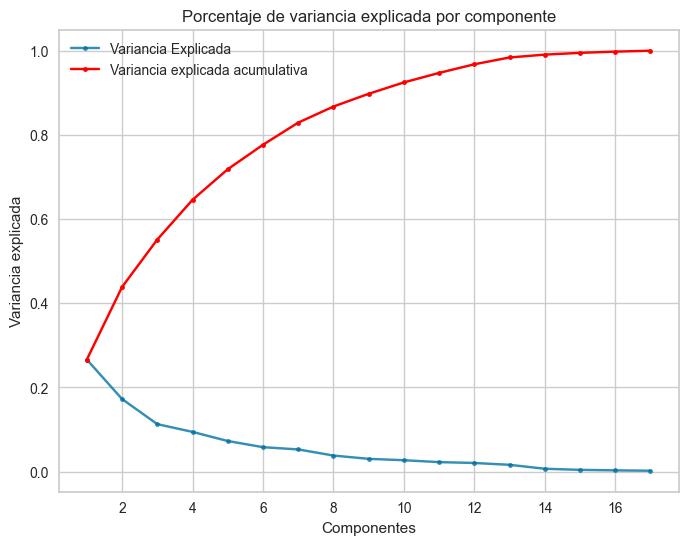

In [6]:
fig = plt.figure(figsize=(8,6));
plt.plot(range(1,len(pca.explained_variance_ratio_ )+1),pca.explained_variance_ratio_ ,alpha=0.8,marker='.',label="Variancia Explicada");
y_label = plt.ylabel('Variancia explicada');
x_label = plt.xlabel('Componentes');
plt.plot(range(1,len(pca.explained_variance_ratio_ )+1),
         np.cumsum(pca.explained_variance_ratio_),
         c='red',marker='.',
         label="Variancia explicada acumulativa");
plt.legend();
plt.title('Porcentaje de variancia explicada por componente');

### K nearest neighbours

In this section we are going to fit k-nn to our data to make the predictions.

Knowning that k-nn works by retrieving the k nearest neighbors based on the distance, so it is important that all the attributes are in the same scale, so the first thing we will do is to normalize our data using MinMax scaler.


In [7]:
scaler = MinMaxScaler()

X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

Now that we have our data ready we will train k-nn classifier with our training data, for that we will explore diferents parameters like the k value, which distance we use, how we combine the distances and which is the index that allows us to recover the neighbours.

Doing this we will be able to get the best k value with the appropiate parameters, and also each k-value will have the same parameters explored, so we can find the best possible combination for each k-value.

In [8]:
knn =  KNeighborsClassifier()
print(np.mean(cross_val_score(knn,X_train_s,y_train,cv=5)))

0.8344760158237865


In [9]:
niter = 15
cv = 5
param = {'n_neighbors':[1, 3, 5, 7, 11, 15], 
          'weights':['distance', 'uniform'], 
          'leaf_size':[1, 5, 10, 20, 30],
          'metric': ['l2', 'l1', 'cosine']}

knn_gs =  GridSearchCV(knn,param,cv=cv, n_jobs=-1)
knn_gs.fit(X_train_s, y_train);

In [10]:
show_html(pd.DataFrame(knn_gs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
130,"{'leaf_size': 20, 'metric': 'l1', 'n_neighbors': 15, 'weights': 'distance'}",0.844,1
94,"{'leaf_size': 10, 'metric': 'l1', 'n_neighbors': 15, 'weights': 'distance'}",0.844,1
58,"{'leaf_size': 5, 'metric': 'l1', 'n_neighbors': 15, 'weights': 'distance'}",0.844,1
22,"{'leaf_size': 1, 'metric': 'l1', 'n_neighbors': 15, 'weights': 'distance'}",0.844,1
166,"{'leaf_size': 30, 'metric': 'l1', 'n_neighbors': 15, 'weights': 'distance'}",0.844,1


Even if we now known that the k-value that gives us the best results is 15, to be able to compare all the k-values , and see if it is worth it to keep exploring bigger values we will take, for each k-value, the best mean_test_score we got, and plot them to see how the mean test score evolves with the k-values and then take a decision.

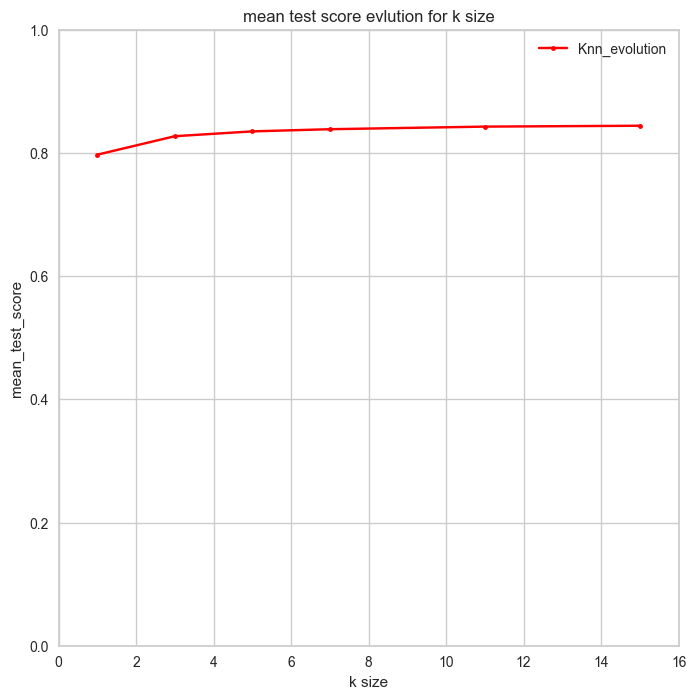

In [12]:
v = pd.DataFrame(knn_gs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score')

#quedar-me amb el maxim per cada num de vesins per tal de fer el plot
dic = {}
for param, score in zip(v["params"],v["mean_test_score"]):
    if param["n_neighbors"] in dic:
        if dic[param["n_neighbors"]] < score:
            dic[param["n_neighbors"]] = score
    else:
        dic[param["n_neighbors"]] = score

plt.figure(figsize=(8,8));
y_label = plt.ylabel('mean_test_score');
x_label = plt.xlabel('k size');
plt.xlim(0,16)
plt.ylim(0,1)
plt.plot(dic.keys(), dic.values(), c='red',marker='.', label="Knn_evolution");
plt.legend();
plt.title('mean test score evlution for k size');

With the plot we can see that there is almost no improvement  between the last 3 different values of k, so probably even if we increase the k-value a lot, the mean test score will barely  change. So there is no need to keep exploring new k-values.

Now we will evaluate the results we got with the best combination of the explored parameters.

In [13]:
print(classification_report(knn_gs.predict(X_test_s), y_test))

              precision    recall  f1-score   support

           0       0.96      0.86      0.91     15074
           1       0.44      0.76      0.56      2247

    accuracy                           0.84     17321
   macro avg       0.70      0.81      0.73     17321
weighted avg       0.89      0.84      0.86     17321



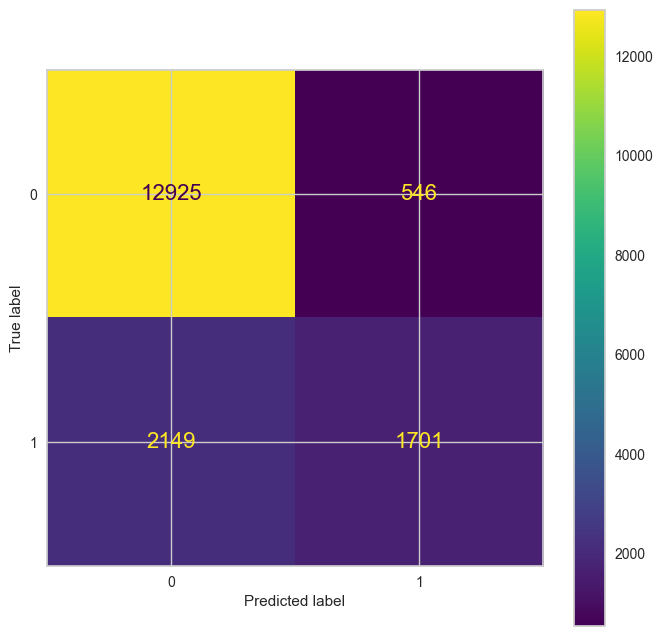

In [14]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(knn_gs, X_test_s,y_test, ax=plt.subplot());

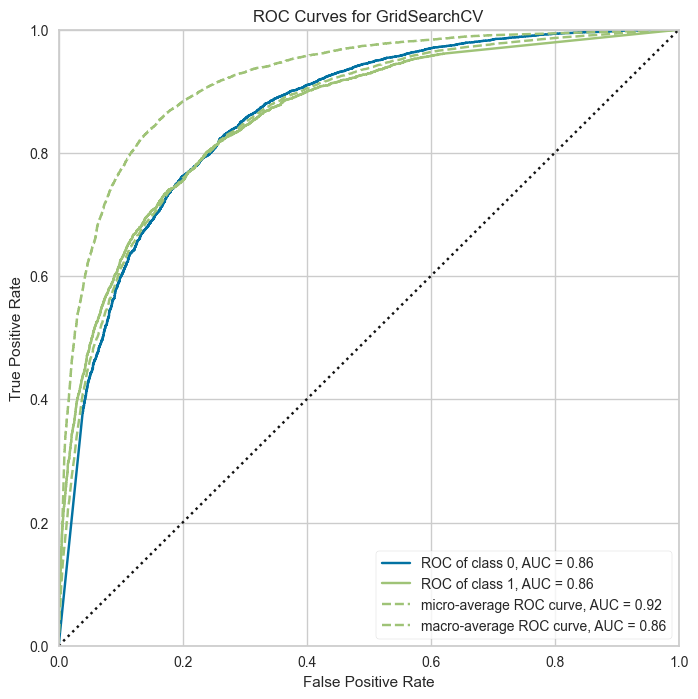

In [15]:
plt.figure(figsize=(8,8));
roc_auc(knn_gs, X_train_s, y_train, X_test_s, y_test);

Our model can predict if tomorrow will not rain really well, having a precision of 0.96 and a recall of 0.86, but it does not do so well with the class 1, having only 0.45 of precision.

That may be due to the fact that the dataset is unbalanced, with most of the cases forming part of the class 0. 

Now to be able to better understand how our model works, we will use permutation importance to see which attribute is more important during the classification.

In [16]:
c = choice(X_test.shape[0], size=1000, replace=False)
pi = permutation_importance(knn_gs,X_test_s[c], y_test.to_numpy()[c], n_jobs=-1, random_state=0)
var_imp = pd.DataFrame({'importance': pi.importances_mean}, index=X.columns)

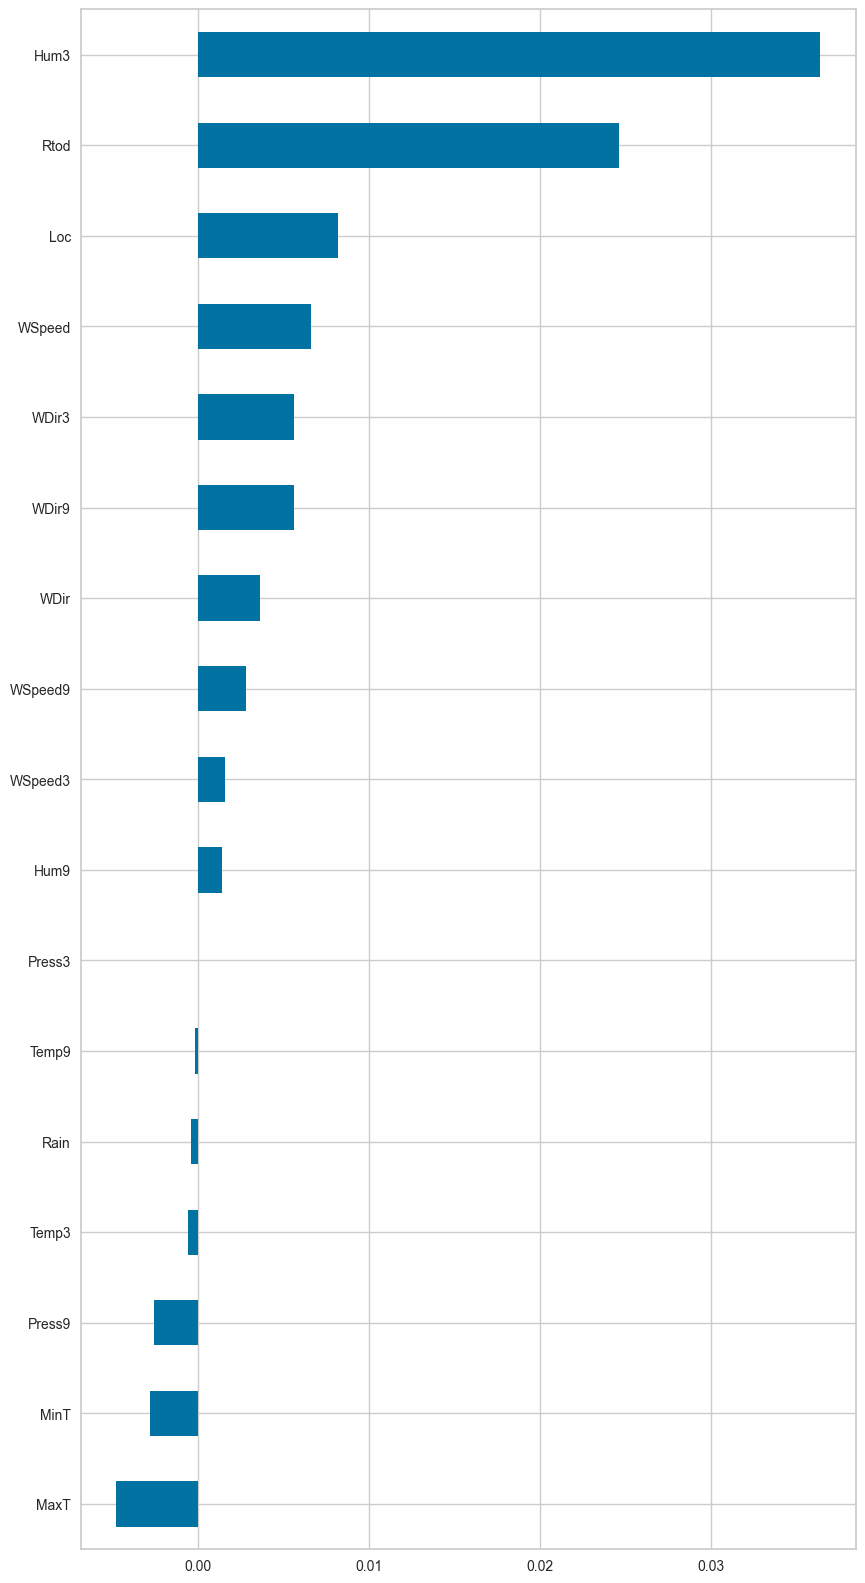

In [17]:
var_imp.sort_values(by='importance').plot.barh(figsize=(10,20), legend=False);

As we can see, the humidity is the most important atribute, and then we have if it rained today, or the wind direction, but with a significant lower impact.

So, seeing that a lot of the atribues we have do not play a relevant role in the classification, we will retrain our model, repeating the steps followed above, with the 6 main components we got from the PCA, which already have arround  80% of the explained variance.

KNN with the main PCA components

In [18]:
nc = 6
X_train_pca = pca.transform(X_train_sd)
X_test_pca = pca.transform(X_test_sd)
X_train_pca_s = scaler.fit_transform(X_train_pca[:,:nc])
X_test_pca_s = scaler.transform(X_test_pca[:,:nc])

In [19]:
knn =  KNeighborsClassifier()
print(np.mean(cross_val_score(knn,X_train_pca_s,y_train,cv=5)))

0.8132441712036889


In [20]:
param = {'n_neighbors':[1, 3, 5, 7, 11, 15], 
          'weights':['distance', 'uniform'], 
          'leaf_size':[1, 5, 10, 20, 30],
          'metric': ['l2', 'l1', 'cosine']}

knn_gs_pca =  GridSearchCV(knn,param,cv=cv, n_jobs=-1)
knn_gs_pca.fit(X_train_pca_s, y_train);

In [21]:
show_html(pd.DataFrame(knn_gs_pca.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
11,"{'leaf_size': 1, 'metric': 'l2', 'n_neighbors': 15, 'weights': 'uniform'}",0.825,1
155,"{'leaf_size': 30, 'metric': 'l2', 'n_neighbors': 15, 'weights': 'uniform'}",0.825,1
119,"{'leaf_size': 20, 'metric': 'l2', 'n_neighbors': 15, 'weights': 'uniform'}",0.825,1
47,"{'leaf_size': 5, 'metric': 'l2', 'n_neighbors': 15, 'weights': 'uniform'}",0.825,1
83,"{'leaf_size': 10, 'metric': 'l2', 'n_neighbors': 15, 'weights': 'uniform'}",0.825,1


In [22]:
print(classification_report(knn_gs_pca.predict(X_test_pca_s), y_test))

              precision    recall  f1-score   support

           0       0.94      0.85      0.90     14883
           1       0.43      0.68      0.53      2438

    accuracy                           0.83     17321
   macro avg       0.69      0.77      0.71     17321
weighted avg       0.87      0.83      0.84     17321



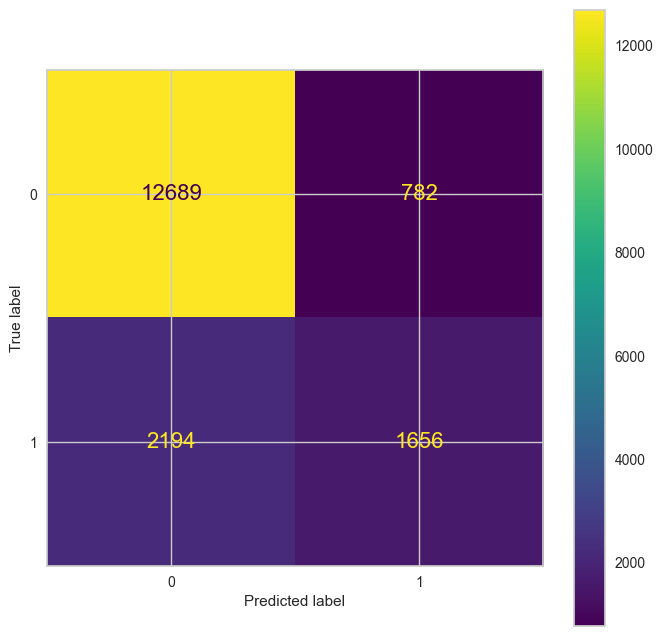

In [23]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(knn_gs_pca, X_test_pca_s,y_test, ax=plt.subplot());

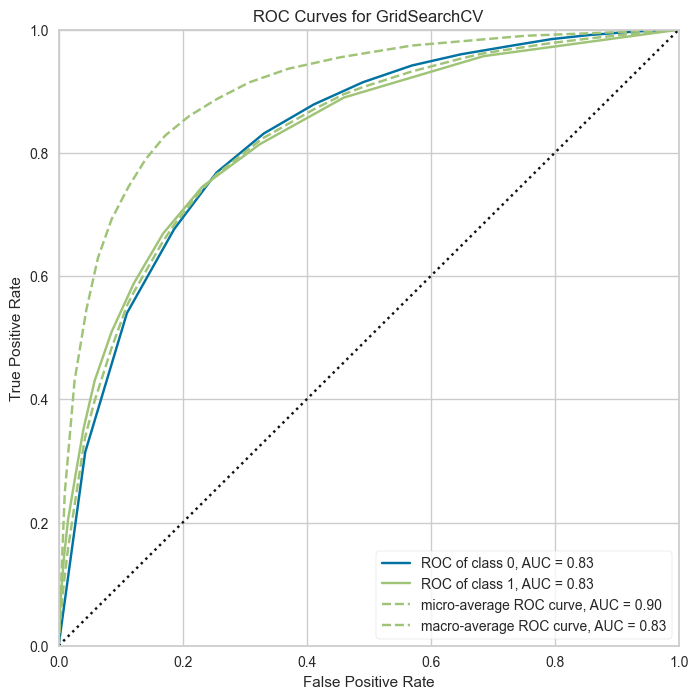

In [25]:
plt.figure(figsize=(8,8));
roc_auc(knn_gs_pca, X_train_pca_s, y_train, X_test_pca_s, y_test);

As we can see the best parameters are almost the same as is the previous model, only changing how we combine the distances using now l2, insted of l1.And even if the best mean test score is lower than the one we got before by 0.018, it is not for much, taking into account that now we use only 6 components, instead of the 17 used before, so if we do not mind our model being a bit worst, but we care about the speed of computation, this last version would be better.